# LangGraph-Add-Query-Rewrite

- Author: [Sunworl Kim](https://github.com/sunworl)
- Design: [LeeYuChul](https://github.com/LeeYuChul)
- Peer Review:
- Proofread:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/sub-graph.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239937-lesson-2-sub-graphs)

## Overview

In this tutorial, we will cover the process of restructuring the original question by incorporating a **Query Rewrite** step. When a user's question is received, it enables more effective searching. While using Naive RAG as a foundation, this process aims for us to add supplementary mechanisms through query rewriting and web search. The procedure is as follows:

1. Perform Naive RAG
2. Conduct Groundedness Check for Retrieved Documents (Groundedness Check)
3. Web Search
4. (This Tutorial) Query Rewrite 

[Note]
As this builds upon a previous tutorial, there may be overlapping content. For any missing explanations, please refer to the previous tutorial.

![image.png](assets/05-langgraph-add-query-rewrite-01.png)



### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Creating a Basic PDF-based Retrieval Chain](#creating-a-basic-pdf-based-retrieval-chain)
- [Defining State](#defining-state)
- [Defining Nodes](#defining-nodes)
- [Adding the Query Rewrite Node](#adding-the-query-rewrite-node)
- [Defining Edges](#defining-edges)
- [Running Graph](#running-graph)


### References

- [langgraph_agentic_rag](https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_agentic_rag.ipynb)

----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 

- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [28]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [29]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_openai",
        "langgraph",
        "typing",
        "langchain_core",
        "langchain-opentutorial"
    ],
    verbose=False,
    upgrade=False,
)

You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [30]:
from dotenv import load_dotenv
from langchain_opentutorial import set_env

# Attempt to load environment variables from a .env file; if unsuccessful, set them manually.
if not load_dotenv():
    set_env(
        {
            "OPENAI_API_KEY": "",
            "LANGCHAIN_API_KEY": "",
            "LANGCHAIN_TRACING_V2": "true",
            "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
            "LANGCHAIN_PROJECT": "05-LangGraph-Add-Query-Rewrite"  
         }
    )

Environment variables have been set successfully.


## Creating a Basic PDF-based Retrieval Chain

Here, we create a Retrieval Chain based on PDF documents. This is the simplest structure of a Retrieval Chain.

However, in LangGraph, the Retriever and Chain are created separately. This allows for detailed processing at each node.

**[Note]**

Detailed explanations for this step can be found in the previous tutorial.


In [31]:
from rag.pdf import PDFRetrievalChain

# Load the PDF document
pdf = PDFRetrievalChain(["data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf"]).create_chain()

# Create retriever and chain
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

## Defining State

The `State` object defines the shared state between nodes in the Graph.

Generally, using a `TypedDict` is to ensure type safety and maintain a clear structure for the graph's state management.

In this case, we'll add a field for relevance check results to the state.

**[Note]**

Here, we define `question` as a list to accomodate the rewritten queries that are additionally stored.

In [32]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# Define GraphState
class GraphState(TypedDict):
    question: Annotated[list[str], add_messages]  # Questions (accumulating list)
    context: Annotated[str, "Context"]  # Search results from documents
    answer: Annotated[str, "Answer"]  # Response
    messages: Annotated[list, add_messages]  # Messages (accumulating list)
    relevance: Annotated[str, "Relevance"]  # Relevance score

## Defining Nodes

`Nodes` represent individual processing steps. They are typically implemented as Python functions. Both input and output are state values.

**[Note]**

Each Node takes a `State` as input, performs its designated logic, and returns an updated `State`.

In [33]:
from langchain_openai import ChatOpenAI
from langchain_opentutorial.evaluator import GroundednessChecker
from langchain_opentutorial.messages import messages_to_history
from langchain_opentutorial.tools.tavily import TavilySearch
from rag.utils import format_docs


# Document retrieval node
def retrieve_document(state: GraphState) -> GraphState:
    # Get the question from the state
    latest_question = state["question"][-1].content

    # Search the documents to find relevant ones
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # Format the retrieved documents (to be used as prompt input)
    retrieved_docs = format_docs(retrieved_docs)

    # Store the retrieved documents in the context key
    return GraphState(context=retrieved_docs)


# Answer generation node
def llm_answer(state: GraphState) -> GraphState:
    # Get the question from the state
    latest_question = state["question"][-1].content

    # Get the retrieved documents from the state
    context = state["context"]

    # Call the chain to generate an answer
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # Store the generated answer and (user question, answer) messages in the state
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }


# Relevance check node
def relevance_check(state: GraphState) -> GraphState:
    # Create a relevance evaluator
    question_answer_relevant = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-4o-mini", temperature=0), target="question-retrieval"
    ).create()

    # Execute relevance check
    response = question_answer_relevant.invoke(
        {"question": state["question"][-1].content, "context": state["context"]}
    )

    # Return the groundedness score
    # Note: The groundedness checker here can be modified using your own prompt. Try creating and using your own Groundedness Check!
    return {"relevance": response.score}


# Function to check relevance (router)
def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"


# Web Search node
def web_search(state: GraphState) -> GraphState:
    # Create search tool
    tavily_tool = TavilySearch()

    search_query = state["question"]

    # Search example using various parameters
    search_result = tavily_tool.search(
        query=search_query,  # Search query
        topic="general",  # General topic
        max_results=6,  # Maximum search results
        format_output=True,  # results format
    )

    return {"context": search_result}

## Adding the Query Rewrite Node

The **Query Rewrite Node** rewrites the original questions, using a prompt designed for query reformulation.

In [34]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Define the prompt template for query rewriting
re_write_prompt = PromptTemplate(
    template="""Reformulate the given question to enhance its effectiveness for vectorstore retrieval.

- Analyze the initial question to identify areas for improvement such as specificity, clarity, and relevance.
- Consider the context and potential keywords that would optimize retrieval.
- Maintain the intent of the original question while enhancing its structure and vocabulary.

# Steps

1. **Understand the Original Question**: Identify the core intent and any keywords.
2. **Enhance Clarity**: Simplify language and ensure the question is direct and to the point.
3. **Optimize for Retrieval**: Add or rearrange keywords for better alignment with vectorstore indexing.
4. **Review**: Ensure the improved question accurately reflects the original intent and is free of ambiguity.

# Output Format

- Provide a single, improved question.
- Do not include any introductory or explanatory text; only the reformulated question.

# Examples

**Input**: 
"What are the benefits of using renewable energy sources over fossil fuels?"

**Output**: 
"How do renewable energy sources compare to fossil fuels in terms of benefits?"

**Input**: 
"How does climate change impact polar bear populations?"

**Output**: 
"What effects does climate change have on polar bear populations?"

# Notes

- Ensure the improved question is concise and contextually relevant.
- Avoid altering the fundamental intent or meaning of the original question.


[REMEMBER] Re-written question should be in the same language as the original question.

# Here is the original question that needs to be rewritten:
{question}
""",
    input_variables=["generation", "question"],
)

question_rewriter = (
    re_write_prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0) | StrOutputParser()
)

This node utilizes a `question_rewriter` function to rewrite the question.

In [35]:
# Query Rewriting
question = "Where has the application of AI in healthcare been confined to so far?"

question_rewriter.invoke({"question": question})

'What are the current applications of AI in healthcare and their limitations?'

In [36]:
# Query Rewrite Node
def query_rewrite(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    question_rewritten = question_rewriter.invoke({"question": latest_question})
    return {"question": question_rewritten}

## Defining Edges

`Edges` determine the next `Node` to execute based on the current `State`.

There are different types such as regular edges and conditional edges.

In [37]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Define graph
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)
workflow.add_node("web_search", web_search)

# Add Query Rewrite node
workflow.add_node("query_rewrite", query_rewrite)

# Add edges
workflow.add_edge("query_rewrite", "retrieve")  # Query rewrite -> Retrieval
workflow.add_edge("retrieve", "relevance_check")  # Retrieval -> Relevance check

# Add conditional edges
workflow.add_conditional_edges(
    "relevance_check",  # Passes the output from relevance check node to is_relevant function
    is_relevant,
    {
        "relevant": "llm_answer",  # If relevant, generate answer
        "not relevant": "web_search",  # If not relevant, perform web search
    },
)

workflow.add_edge("web_search", "llm_answer")  # Web search -> Answer
workflow.add_edge("llm_answer", END)  # Answer -> End

# Set graph entry point
workflow.set_entry_point("query_rewrite")

# Set checkpointer
memory = MemorySaver()

# Compile graph
app = workflow.compile(checkpointer=memory)

Let's visualize the compiled graph structure.

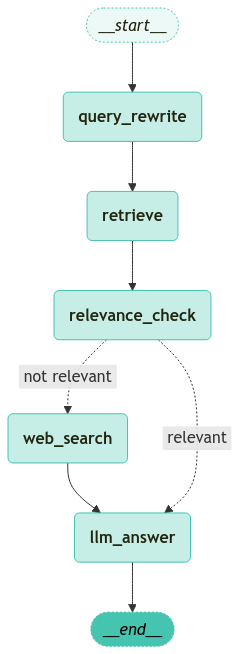

In [38]:
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(app)

## Running Graph

- `config` parameter: Passes configuration settings required for running the graph.

- `recursion_limit`: Sets a limit on the number of recursions when running the graph.

- `inputs`: Passes the input information required for running the graph.


If the `relevance_check` of the initial search results fails, it performs web search and provides web search results.

In [39]:
from langchain_core.runnables import RunnableConfig
from langchain_opentutorial.messages import stream_graph, invoke_graph, random_uuid
from langgraph.errors import GraphRecursionError

# Configure settings (max recursion count, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# Input question
inputs = GraphState(question="Where has the application of AI in healthcare been confined to so far?")

# Execute the graph
try:
    invoke_graph(app, inputs, config)
    outputs = app.get_state(config)

    # Access the values dictionary within StateSnapshot
    output_values = outputs.values

    # Display the results
    print("\n--- OUTPUTS ---\n")
    print("Question:", output_values["question"])
    print("Answer:\n", output_values["answer"])
    print("Relevance:", output_values["relevance"])
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")
except Exception as e:
    print(f"Unexpected Error: {e}")


🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
question:
What are the current applications of AI in healthcare?

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>activities. So far, however, AI applications in healthcare have been potential. Specific healthcare training should be provided to data
confined to administrative tasks (i.e., Natural Language Processing scientists working in hospitals so that they can better understand</content><source>data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf</source><page>15</page></document>
<document><content>are great, as more use of AI in research and development could
Healthcare is arguably the sector where AI could make the lead to a more personalised healthcare based on patients’ data.</content><source>data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf</source><page>15</page></document>
<document><content>same

The evaluator summarized above follows this.

In [40]:
# Running graph
stream_graph(app, inputs, config, ["query_rewrite", "llm_answer"])


🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
What are the current applications of AI in healthcare and their limitations?
🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Current applications of AI in healthcare include remote monitoring, AI-powered alerting, predictive maintenance, and personalized healthcare based on patient data. However, limitations include organizational and skill challenges, concerns over data ownership and privacy, and the need for better communication between data experts and healthcare professionals.

**Source**
- data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf (pages 4, 15, 16)

In [41]:
# Check final outputs
outputs = app.get_state(config).values

print(f'Original Question: {outputs["question"][0].content}')
print(f'Rewritten Question: {outputs["question"][-1].content}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Original Question: Where has the application of AI in healthcare been confined to so far?
Rewritten Question: What are the current applications of AI in healthcare and their limitations?
Answer:
Current applications of AI in healthcare include remote monitoring, AI-powered alerting, predictive maintenance, and personalized healthcare based on patient data. However, limitations include organizational and skill challenges, concerns over data ownership and privacy, and the need for better communication between data experts and healthcare professionals.

**Source**
- data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf (pages 4, 15, 16)
